# dN/dS ratio in SARS-CoV-2

The dN/dS ratio can be used to estimate the selective pressure.
Here we aim at exploring the evolution of the dN/dS ratio through time across different countries and genes.

For that purpose we will explore the results from ENA (queried on 09/10/2021, n=50,589) and from GISAID (queried on 17/08/2021, n=2,148,528).

We are interested in understanding how the introduction of vaccines was reflected in SARS-CoV-2 evolution.
For this purpose we are loading the dataset from Our World In Data (Mathieu, 2021) queried on the 17/09/2021 from https://covid.ourworldindata.org/data/owid-covid-data.csv.

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
sns.set_context("talk")
sns.color_palette("colorblind")

from src.plots import *

## Data loading

In [2]:
data_folder = '/data'
local_data_folder = './data'
figures_folder = './figures'

### Read samples tables

In [3]:
samples_ena = pd.read_csv(os.path.join(data_folder, 'sample_ena.csv.gz'))
ena_num_samples = samples_ena[samples_ena.status == 'FINISHED'].shape[0]
ena_num_samples

84125

In [4]:
samples_gisaid = pd.read_csv(os.path.join(data_folder, 'sample_gisaid.csv.gz'))
gisaid_num_samples = samples_gisaid[samples_gisaid.status == 'FINISHED'].shape[0]
gisaid_num_samples

2151802

In [5]:
last_updates = pd.read_csv(os.path.join(data_folder, 'last_update.csv.gz'))
gisaid_download_date = last_updates[last_updates.source == 'GISAID'].update_time.iloc[0]
ena_download_date = last_updates[last_updates.source == 'ENA'].update_time.iloc[0]
last_updates

id update_time  source
0   1  2022-02-17     ENA
1   2  2021-08-17  GISAID

### Read the fractions of possible NS and S mutations in the reference

This represents the fraction of non-sysnonymous (NS) and synonymous (S) mutations at each coding position in the reference sequence. Considering random mutations the ratio between non-synonymous and synonymous mutations should be similar to the ratio of NS and S.

The code to compute these is in `"./src/calculate_NS_S.py"`

This information is relevant at gene and domain levels. It may be possible to increase granularity to the codon.

In [6]:
counts_fractions_ns_s = pd.read_csv(os.path.join(local_data_folder, 'genes_NS_S.csv'))
# we perform this grouping to remove the alternative ORF1ab, we only consider the biggest as they are equivalent and we do not count overlaps in CoVigator
counts_fractions_ns_s = counts_fractions_ns_s.groupby(["gene"]).max().reset_index()
counts_fractions_ns_s

gene          transcript            NS            S
0        E  ENSSAST00005000010    170.000000    58.000000
1        M  ENSSAST00005000007    512.000000   157.000000
2        N  ENSSAST00005000005    971.333333   288.666667
3    ORF10  ENSSAST00005000013     92.666667    24.333333
4   ORF1ab  ENSSAST00005000003  16656.000000  4635.000000
5    ORF3a  ENSSAST00005000006    643.666667   184.333333
6     ORF6  ENSSAST00005000011    149.666667    36.333333
7    ORF7a  ENSSAST00005000009    282.000000    84.000000
8    ORF7b  ENSSAST00005000012    105.333333    26.666667
9     ORF8  ENSSAST00005000008    289.000000    77.000000
10       S  ENSSAST00005000004   2975.000000   847.000000

In [7]:
ns_coding_region = counts_fractions_ns_s.NS.sum()
s_coding_region = counts_fractions_ns_s.S.sum()
print("NS={} and S={} on the coding region".format(ns_coding_region, s_coding_region))

NS=22846.666666666668 and S=6418.333333333333 on the coding region


In [8]:
genes = list(counts_fractions_ns_s.gene)
genes

['E',
 'M',
 'N',
 'ORF10',
 'ORF1ab',
 'ORF3a',
 'ORF6',
 'ORF7a',
 'ORF7b',
 'ORF8',
 'S']

In [9]:
counts_fractions_ns_s_domain = pd.read_csv(os.path.join(local_data_folder, 'domains_NS_S.csv'))
counts_fractions_ns_s_domain.head()

transcript   gene          domain  start   end           NS  \
0  ENSSAST00005000004      S          CoV_S2   2130  3693  1218.333333   
1  ENSSAST00005000004      S     bCoV_S1_RBD   1044  1575   414.000000   
2  ENSSAST00005000004      S       bCoV_S1_N     96  1008   714.000000   
3  ENSSAST00005000004      S        CoV_S1_C   1605  1773   130.000000   
4  ENSSAST00005000006  ORF3a  bCoV_viroporin      0   819   637.000000   

            S  
0  344.666667  
1  117.000000  
2  198.000000  
3   38.000000  
4  182.000000

In [10]:
genes_domains = counts_fractions_ns_s_domain[["gene", "domain"]].drop_duplicates()
genes_domains.head()

gene          domain
0      S          CoV_S2
1      S     bCoV_S1_RBD
2      S       bCoV_S1_N
3      S        CoV_S1_C
4  ORF3a  bCoV_viroporin

### Counts of mutations in GISAID and ENA samples

Here we load the counts of non-synonymous and synomymous mutations across GISAID SARS-CoV-2 samples in CoVigator.
This is a simplification as multiple mutations in the same codon are evaluated independently. If we were to evaluate them jointly we would need to consider all possible paths that lead to the observed combination of mutations. In the case of two substitutions this is only two paths, but in the case of three substitutions this is six paths.

In [11]:
counts_mutations_ns_s = pd.read_csv(os.path.join(data_folder, 'precomputed_ns_s_counts.csv.gz'))
counts_mutations_ns_s.head()

id       month region_type region_name    country  source  ns   s
0  129712  2020-12-01      DOMAIN    NSP9_CoV  Guatemala  GISAID   1   1
1  129713  2020-12-01      DOMAIN    NSP9_CoV    Iceland  GISAID  18   5
2  129714  2020-12-01      DOMAIN    NSP9_CoV      India  GISAID  65  66
3  129715  2020-12-01      DOMAIN    NSP9_CoV  Indonesia  GISAID   4  13
4  129716  2020-12-01      DOMAIN    NSP9_CoV    Ireland  GISAID  10   2

In [12]:
genes_counts_mutations_ns_s = counts_mutations_ns_s[counts_mutations_ns_s.region_type == 'GENE']
genes_counts_mutations_ns_s.head()

id       month region_type region_name         country source  ns   s
4365  88161  2020-01-01        GENE           E           Spain    ENA  23   5
4678  88162  2020-01-01        GENE           M           China    ENA   0   1
4989  88163  2020-01-01        GENE           M         Nigeria    ENA   0   1
4990  88164  2020-01-01        GENE           M           Spain    ENA  15  59
4991  88165  2020-01-01        GENE           M  United Kingdom    ENA   9  22

In [13]:
domain_counts_mutations_ns_s = counts_mutations_ns_s[counts_mutations_ns_s.region_type == 'DOMAIN']
domain_counts_mutations_ns_s = pd.merge(domain_counts_mutations_ns_s, genes_domains, left_on="region_name", right_on="domain")
domain_counts_mutations_ns_s.head()

id       month region_type region_name      country  source  ns   s  \
0  130524  2021-01-01      DOMAIN   bCoV_S1_N  Afghanistan  GISAID   0  14   
1  130525  2021-01-01      DOMAIN   bCoV_S1_N      Albania  GISAID   1   1   
2  130526  2021-01-01      DOMAIN   bCoV_S1_N       Angola  GISAID  35  11   
3  130527  2021-01-01      DOMAIN   bCoV_S1_N    Argentina  GISAID  11   3   
4  130528  2021-01-01      DOMAIN   bCoV_S1_N      Armenia  GISAID   6  22   

  gene     domain  
0    S  bCoV_S1_N  
1    S  bCoV_S1_N  
2    S  bCoV_S1_N  
3    S  bCoV_S1_N  
4    S  bCoV_S1_N

### Vaccination data from Our World In Data

Our World In Data (OWID) provides a web dashboard and access to the raw data in the vaccination status across the globe.  Our World In Data (Mathieu, 2021) queried on the 17/09/2021 from https://covid.ourworldindata.org/data/owid-covid-data.csv.

In [14]:
owid_download_date = "17/09/2021"
vaccination_data = pd.read_csv(os.path.join(local_data_folder, 'owid-covid-data.csv'))
vaccination_data.date = pd.to_datetime(vaccination_data.date)
vaccination_data.head()

iso_code continent     location       date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan 2020-02-24          5.0        5.0   
1      AFG      Asia  Afghanistan 2020-02-25          5.0        0.0   
2      AFG      Asia  Afghanistan 2020-02-26          5.0        0.0   
3      AFG      Asia  Afghanistan 2020-02-27          5.0        0.0   
4      AFG      Asia  Afghanistan 2020-02-28          5.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   extreme_poverty  cardiovasc_death_rate  diabetes_prevalence  \
0              NaN                597.029                 9.59   
1              NaN                597.029                 9.59   
2              NaN                597.029                 9.59   
3              NaN                597.029                 9.59   
4              NaN                597.029                 9.59   

   female_smokers  male_smokers  handwashing_facilities  \
0             NaN           NaN                  37.746   
1             NaN           NaN                  37.746   
2             NaN           NaN                  37.746   
3             NaN           NaN                  37.746   
4             NaN           NaN                  37.746   

   hospital_beds_per_thousand  life_expectancy  human_development_index  \
0                         0.5            64.83                    0.511   
1                         0.5            64.83                    0.511   
2                         0.5            64.83                    0.511   
3                         0.5            64.83                    0.511   
4                         0.5            64.83                    0.511   

   excess_mortality  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  

[5 rows x 62 columns]

In [15]:
print(vaccination_data.columns)

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [16]:
vaccination_data[vaccination_data.location == "United Kingdom"][["location", "date", "people_vaccinated_per_hundred", "people_fully_vaccinated_per_hundred"]].tail()

location       date  people_vaccinated_per_hundred  \
111098  United Kingdom 2021-09-12                          71.02   
111099  United Kingdom 2021-09-13                          71.05   
111100  United Kingdom 2021-09-14                          71.08   
111101  United Kingdom 2021-09-15                          71.11   
111102  United Kingdom 2021-09-16                            NaN   

        people_fully_vaccinated_per_hundred  
111098                                64.58  
111099                                64.67  
111100                                64.76  
111101                                64.85  
111102                                  NaN

### Vaciness approvals

The dates of the approvals of the different vaccines by the US, EU and UK were collected from https://ec.europa.eu/info/live-work-travel-eu/coronavirus-response/timeline-eu-action_en

In [17]:
approvals = pd.DataFrame(
    [
        [datetime(2020, 12, 11), "FDA approves BNT"],
        [datetime(2020, 12, 18), "FDA approves Moderna"],
        [datetime(2021, 2, 27), "FDA approves J&J"],
        [datetime(2020, 12, 30), "UK approves AZ"],
        [datetime(2020, 12, 21), "EU approves BNT"],
        [datetime(2021, 1, 6), "EU approves Moderna"],
        [datetime(2021, 1, 29), "EU approves AZ"],
    ], 
    columns= ["date", "event"])
approvals.head()

date                 event
0 2020-12-11      FDA approves BNT
1 2020-12-18  FDA approves Moderna
2 2021-02-27      FDA approves J&J
3 2020-12-30        UK approves AZ
4 2020-12-21       EU approves BNT

## Methods

### dN/dS

The dN/dS is calculated as described in Nei and Gojobori (1986) with a notable exception.
Once we have the ratios of observed and possible mutations, `pn = n / N` and `ps = s / S`, a log transformation is applied. But the original formula, assumes that `n << N` as it was conceived for the comparison of two sequences. In our case `n` is an observation across many samples and in some cases `n > N`. Thus, the log transformation is simplified into `ln(1 + p)` instead of `3/4 * ln(1 - (3/4 * p))`.

In [18]:
# test
calculate_dn_ds(n=42, s=65, N=2300.66, S=699.33)

0.20355117868756803

In [19]:
calculate_dn_ds(n=48498, s=35256, N=2300.66, S=699.33)

0.7854682041984099

## Figures

### Vaccine approvals

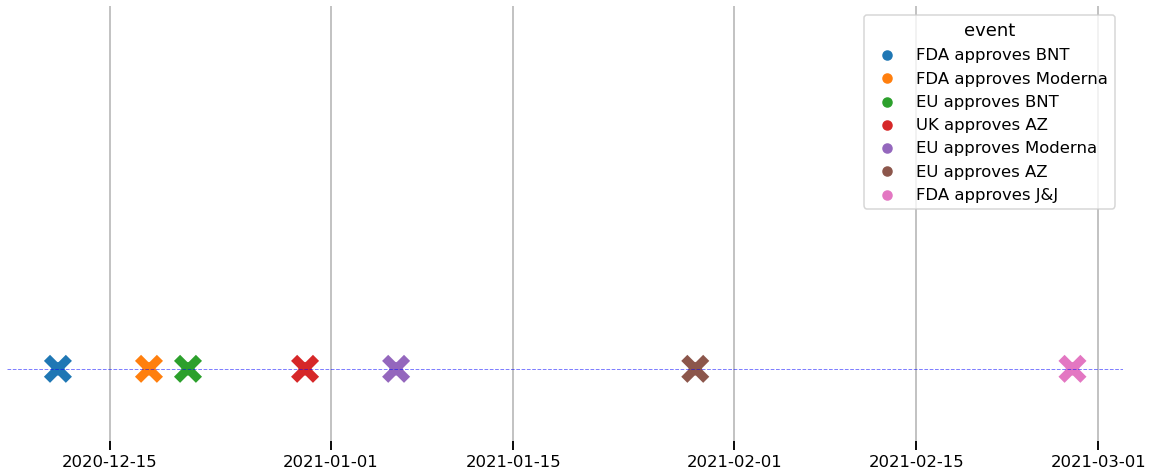

In [20]:
plt.figure(figsize=(20, 8))
#sns.lineplot(data=approvals, x="date")
g = sns.scatterplot(data=approvals.sort_values("date"), x="date", y=0, hue="event", marker='X', s=1000)  ##markers={'marker':'X', 'size':10})
plt.axhline(y=0, color='b', linestyle='--', alpha=0.5, linewidth=1)
sns.despine(bottom=True, left=True)
g.set(yticklabels=[])  
g.set(ylabel=None)
g.set(xlabel=None)
g.tick_params(left=False)
plt.ylim([-0.1, 0.5])
plt.grid(axis="x")
plt.savefig(os.path.join(figures_folder, "vaccine_approvals.jpg"))

### Vaccination by country

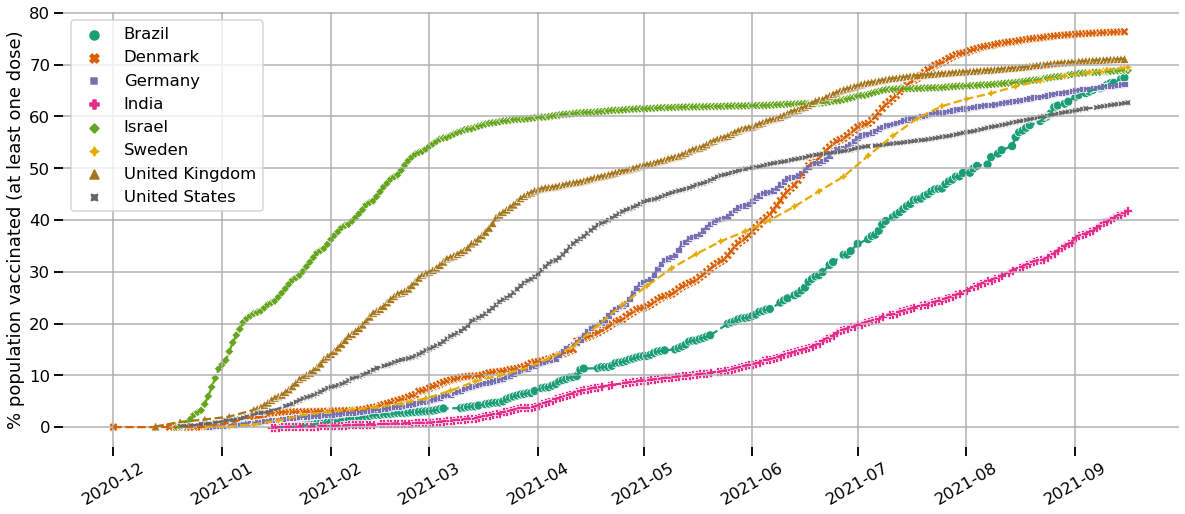

In [21]:
countries_of_interest =  ["United Kingdom", "United States", "Germany", "Denmark", "Sweden", "Israel", "India", "Brazil"]
data_to_plot = vaccination_data[vaccination_data.location.isin(countries_of_interest)][["location", "date", "people_vaccinated_per_hundred", "people_fully_vaccinated_per_hundred"]]

plt.figure(figsize=(20, 8))
sns.lineplot(data=data_to_plot, x="date", y="people_vaccinated_per_hundred", hue="location", legend=False, linestyle="--", palette='Dark2')
sns.scatterplot(data=data_to_plot, x="date", y="people_vaccinated_per_hundred", hue="location", style="location", legend=True, palette='Dark2')
plt.xticks(rotation=30)
plt.title("")
plt.ylabel("% population vaccinated (at least one dose)")
plt.xlabel(None)
plt.legend(title=None)
plt.grid(axis="x")
plt.grid(axis="y")
sns.despine(bottom=True, left=True)
plt.savefig(os.path.join(figures_folder, "people_vaccinated_per_hundred.png"))

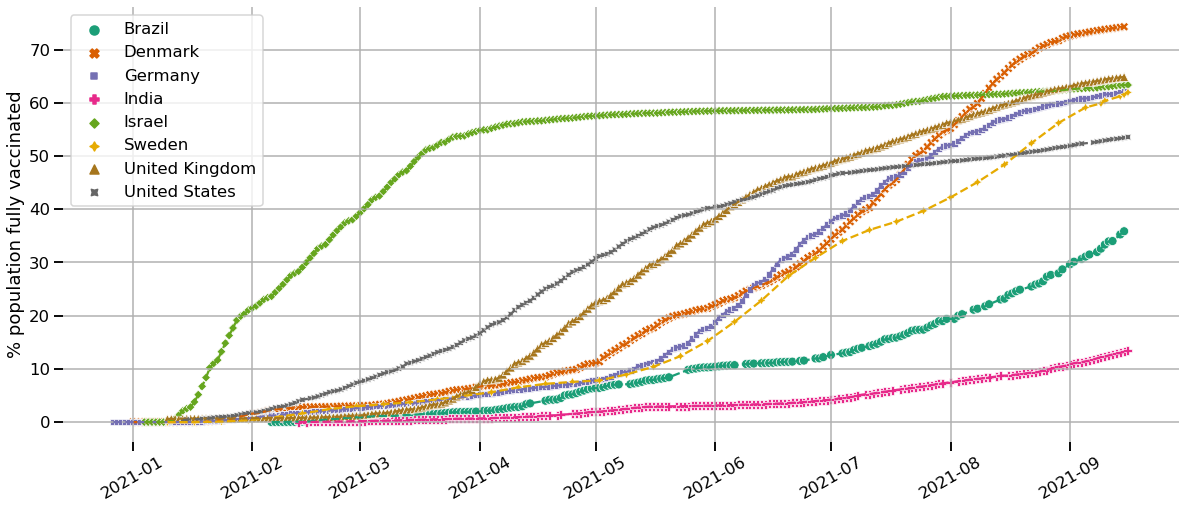

In [22]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=data_to_plot, x="date", y="people_fully_vaccinated_per_hundred", hue="location", legend=False, linestyle="--", palette='Dark2')
sns.scatterplot(data=data_to_plot, x="date", y="people_fully_vaccinated_per_hundred", hue="location", style="location", legend=True, palette='Dark2')
plt.xticks(rotation=30)
plt.title("")
plt.ylabel("% population fully vaccinated")
plt.xlabel(None)
plt.legend(title=None)
plt.grid(axis="x")
plt.grid(axis="y")
sns.despine(bottom=True, left=True)
plt.savefig(os.path.join(figures_folder, "people_fully_vaccinated_per_hundred.png"))

### dN/dS by data source

Compares the evolution of the dN/dS ratio for both GISAID and ENA datasets.

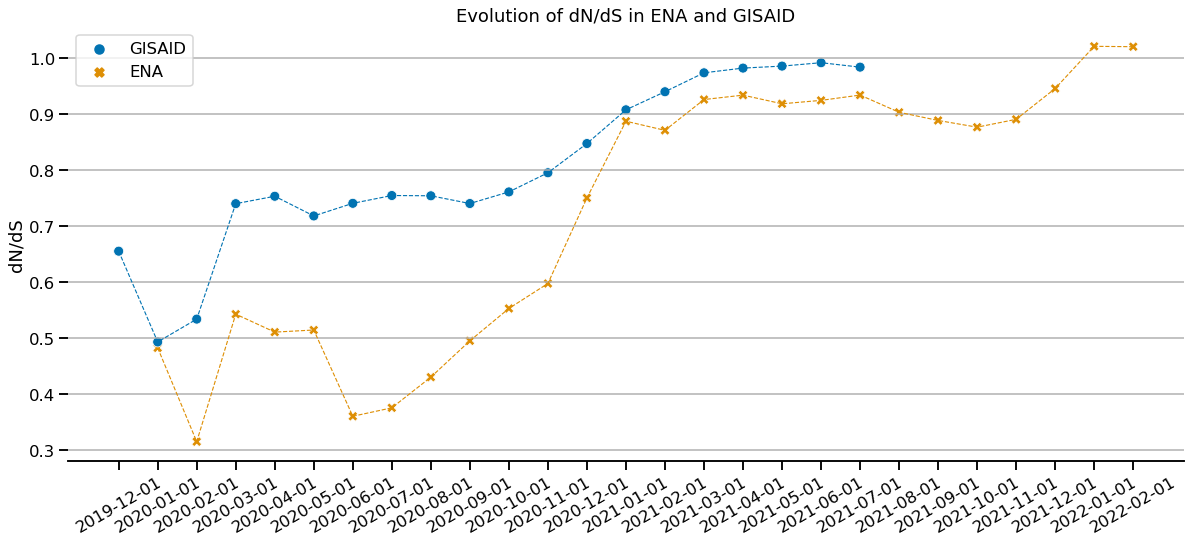

In [23]:
plot_dn_ds_overall(
        data=genes_counts_mutations_ns_s, 
        S=s_coding_region, N=ns_coding_region,
        title="Evolution of dN/dS in ENA and GISAID".format(
            gene=g, date=ena_download_date, num_samples=ena_num_samples), 
        filename=os.path.join(figures_folder, "dn_ds_ena_vs_gisaid.png")
    )

### dN/dS by gene and country

Plot the evolution month by month of the dN/dS on each of the SARS-CoV-2 genes by country.
Only top 5 countries in each dataset are plot, plus in some cases extreme cases chosen arbitrarily.

#### ENA

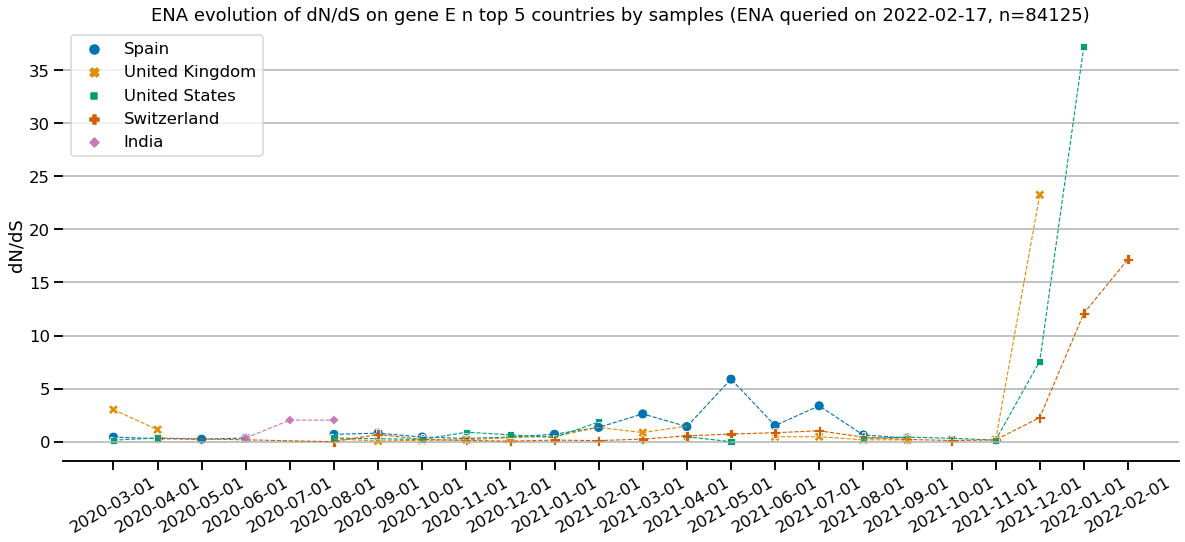

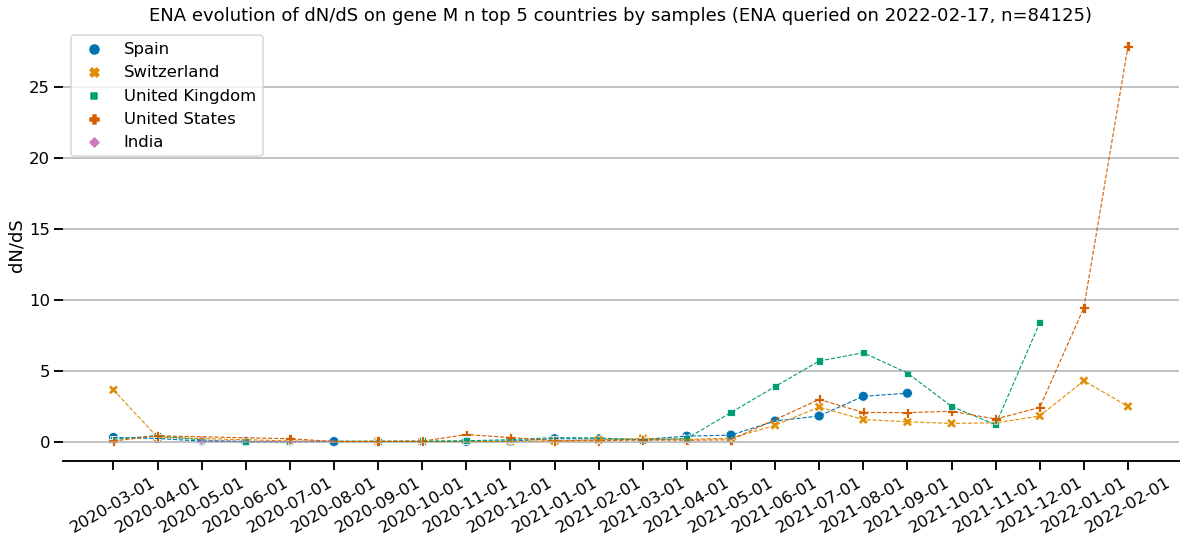

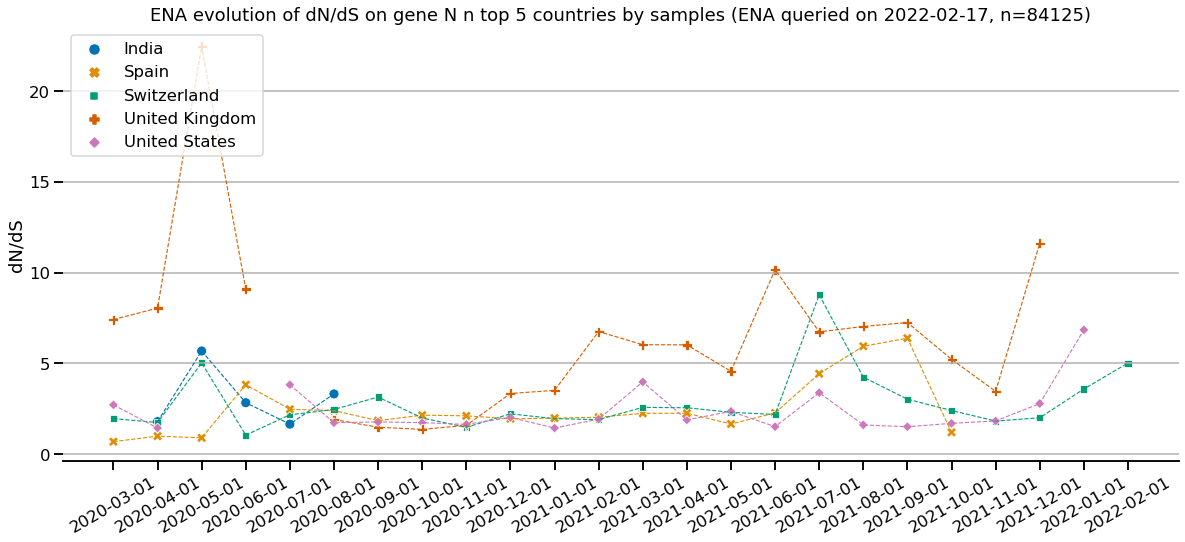

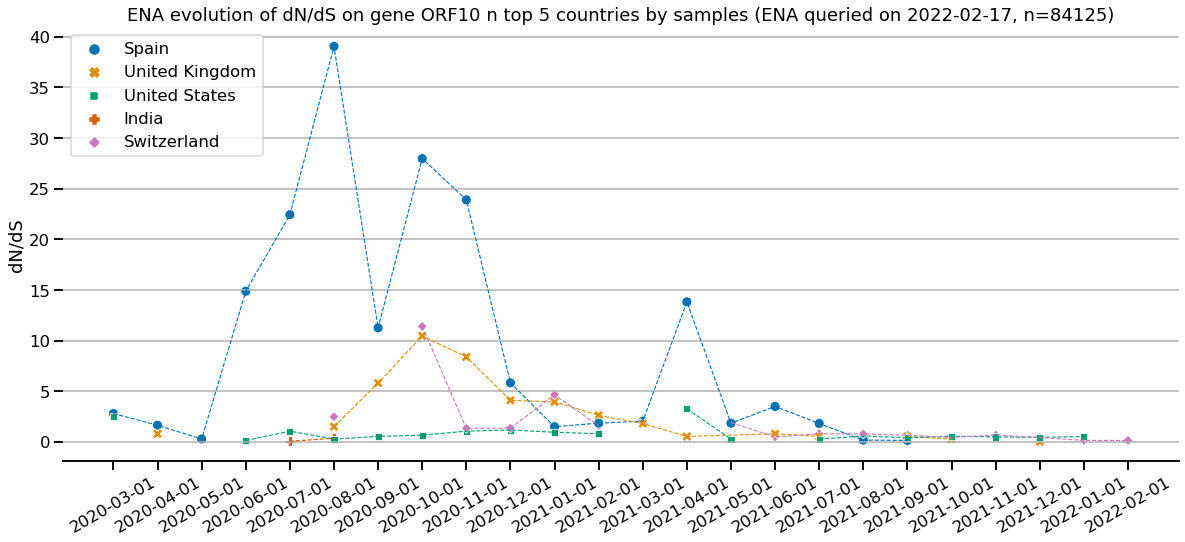

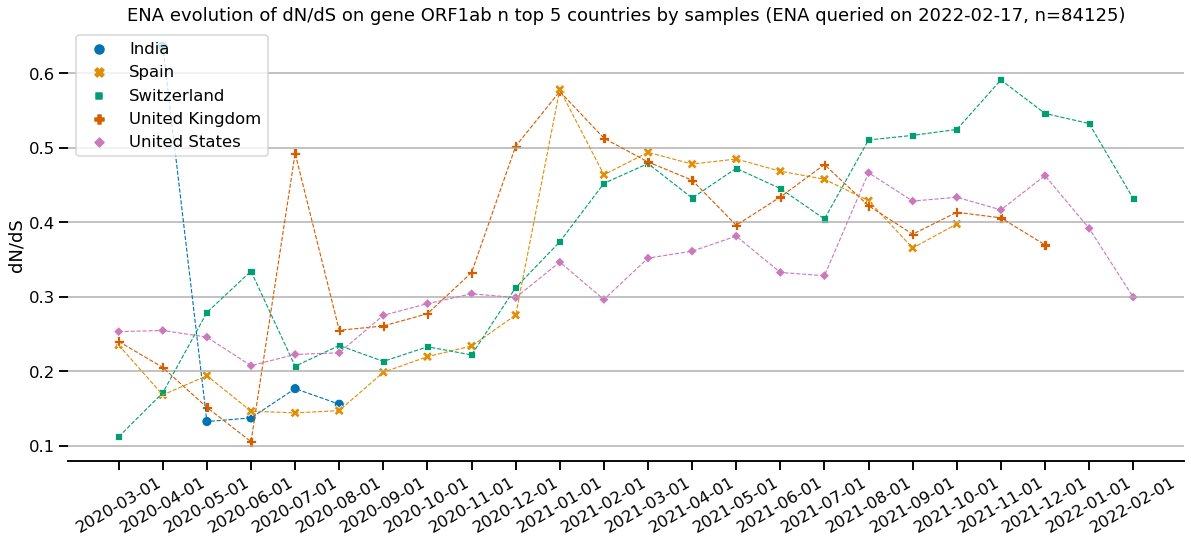

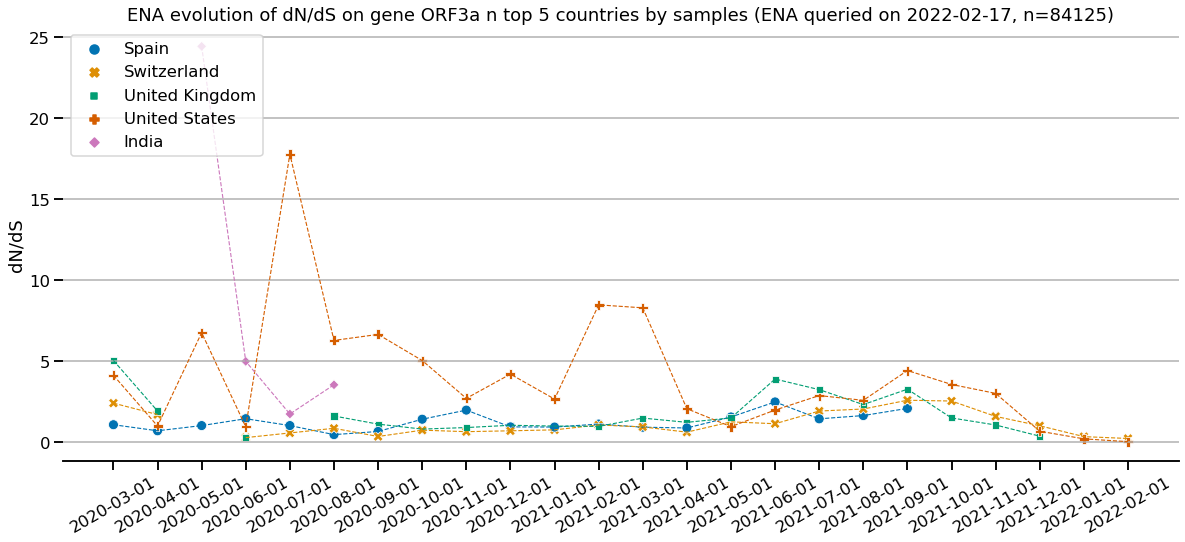

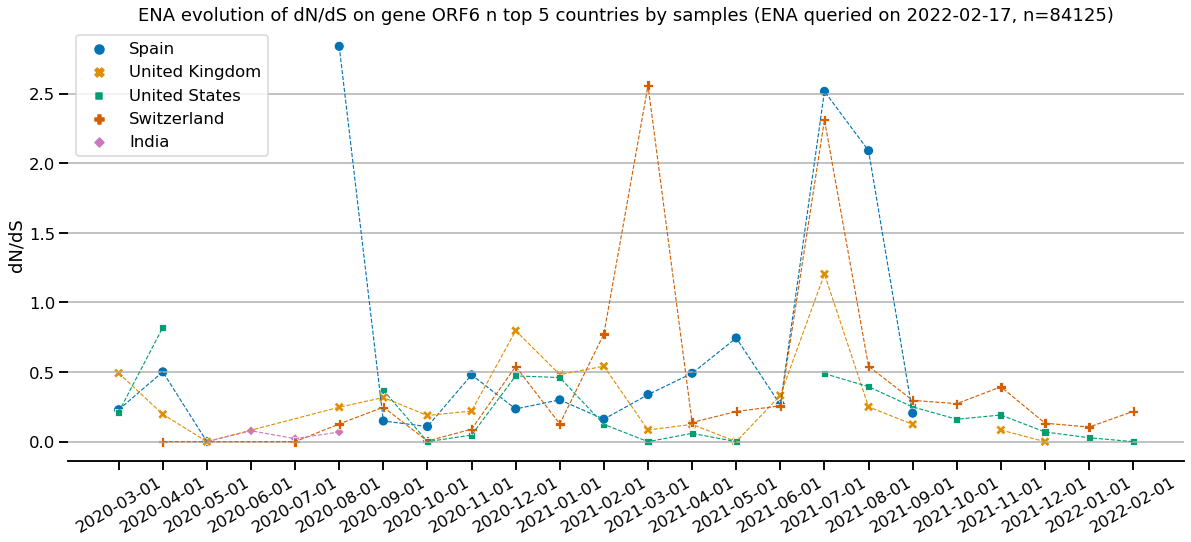

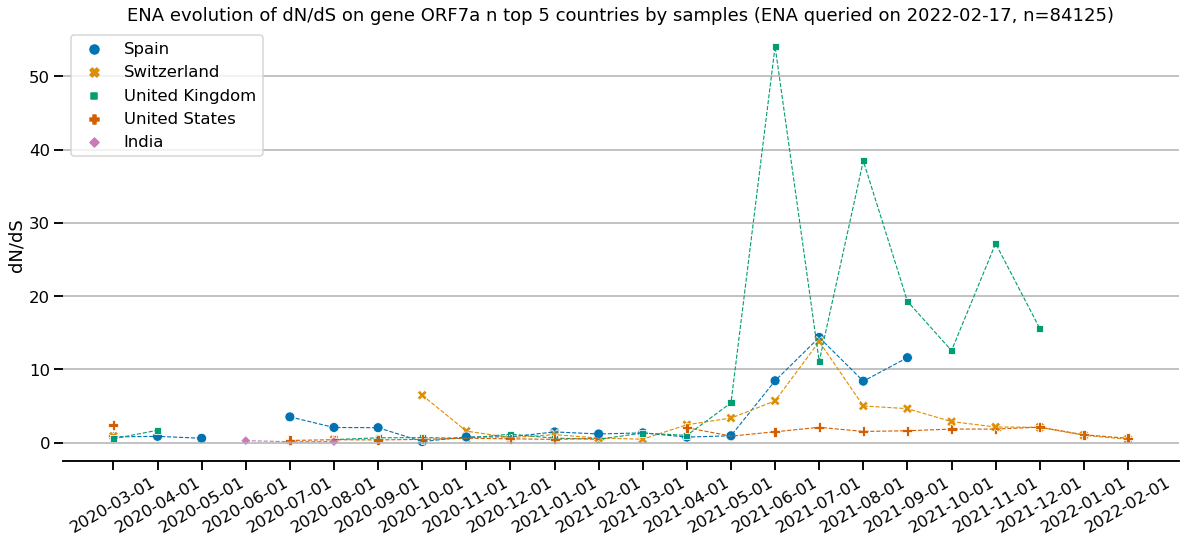

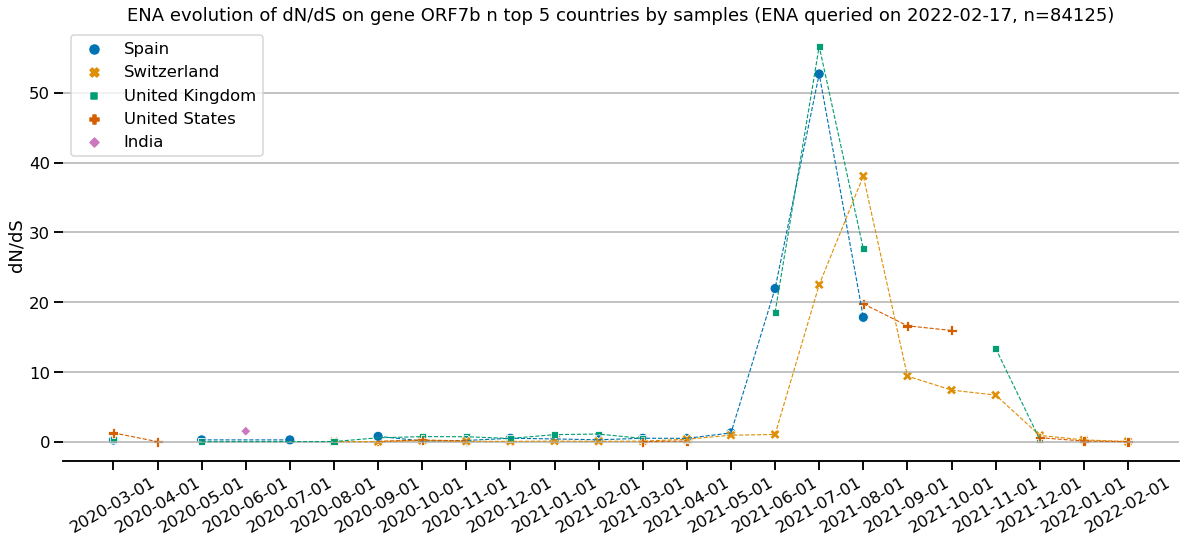

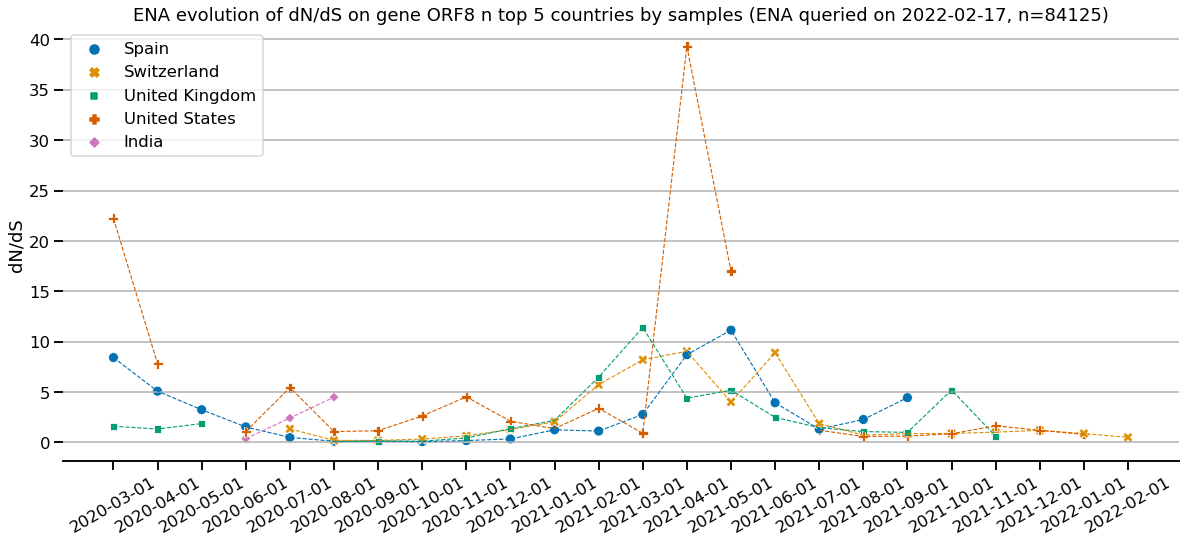

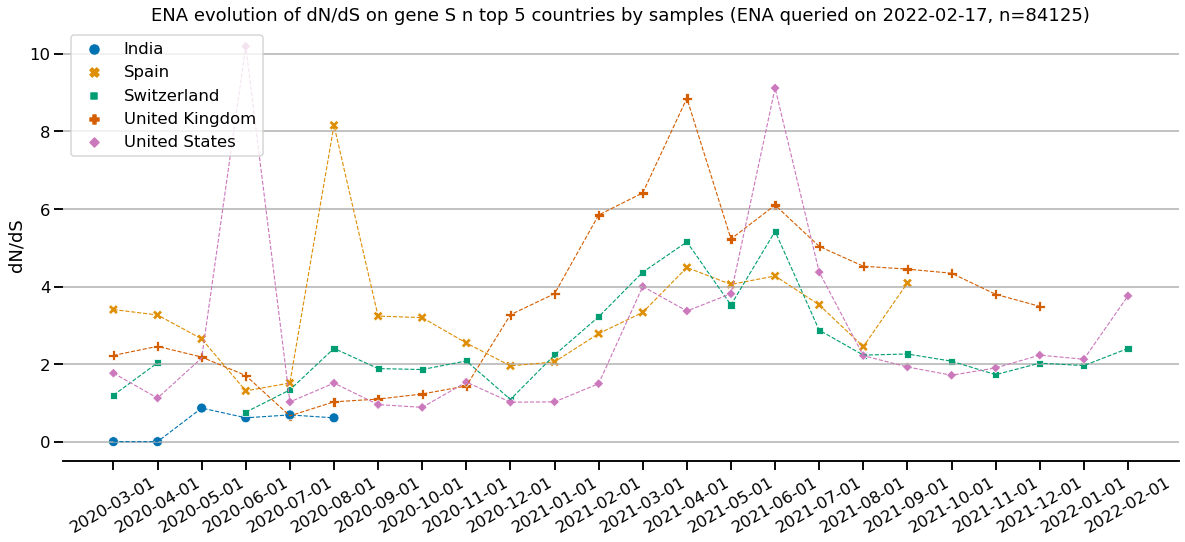

In [24]:
for g in genes:
    top_countries_ena = ["United Kingdom", "United States", "India", "Spain", "Switzerland"]
    plot_dn_ds_by_country(
        data=genes_counts_mutations_ns_s[
            (genes_counts_mutations_ns_s.source == "ENA") & 
            (genes_counts_mutations_ns_s.region_name == g) & 
            (genes_counts_mutations_ns_s.country.isin(top_countries_ena)) & 
            (genes_counts_mutations_ns_s.month >= "2020-03-01")], 
        title="ENA evolution of dN/dS on gene {gene} n top 5 countries by samples (ENA queried on {date}, n={num_samples})".format(
            gene=g, date=ena_download_date, num_samples=ena_num_samples), 
        filename=os.path.join(figures_folder, "dn_ds_{gene}_by_month_top5_countries_ena.png".format(gene=g)),
        N=counts_fractions_ns_s[counts_fractions_ns_s.gene == g].NS.iloc[0],
        S=counts_fractions_ns_s[counts_fractions_ns_s.gene == g].S.iloc[0]
    )

#### GISAID

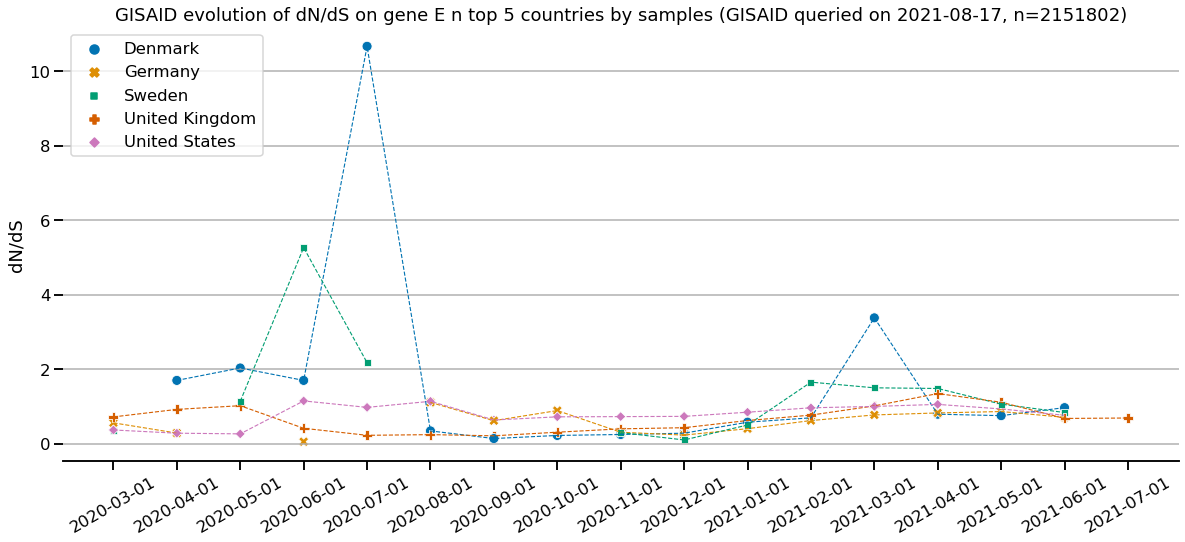

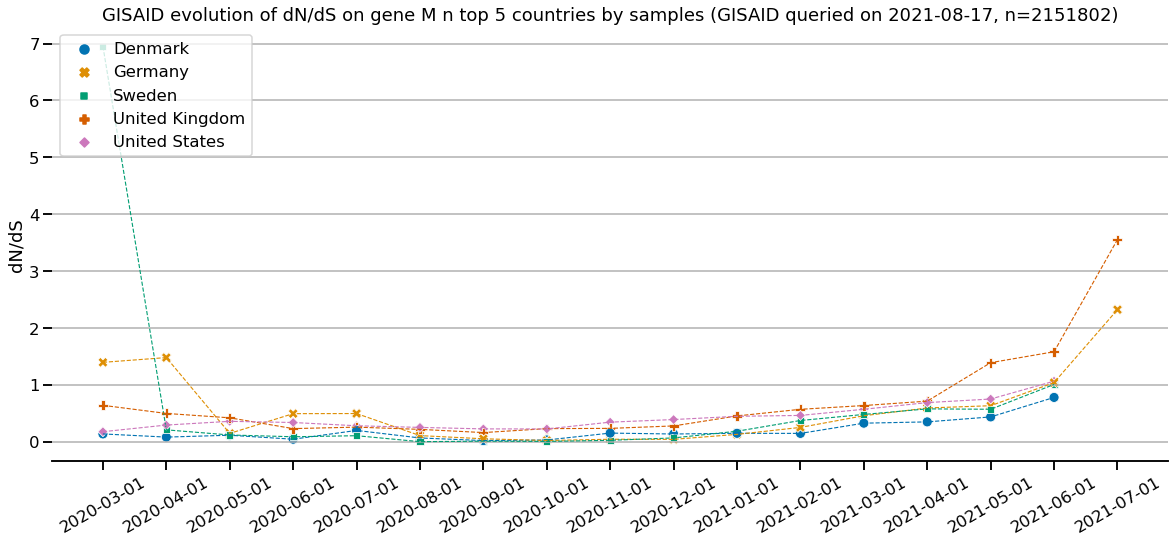

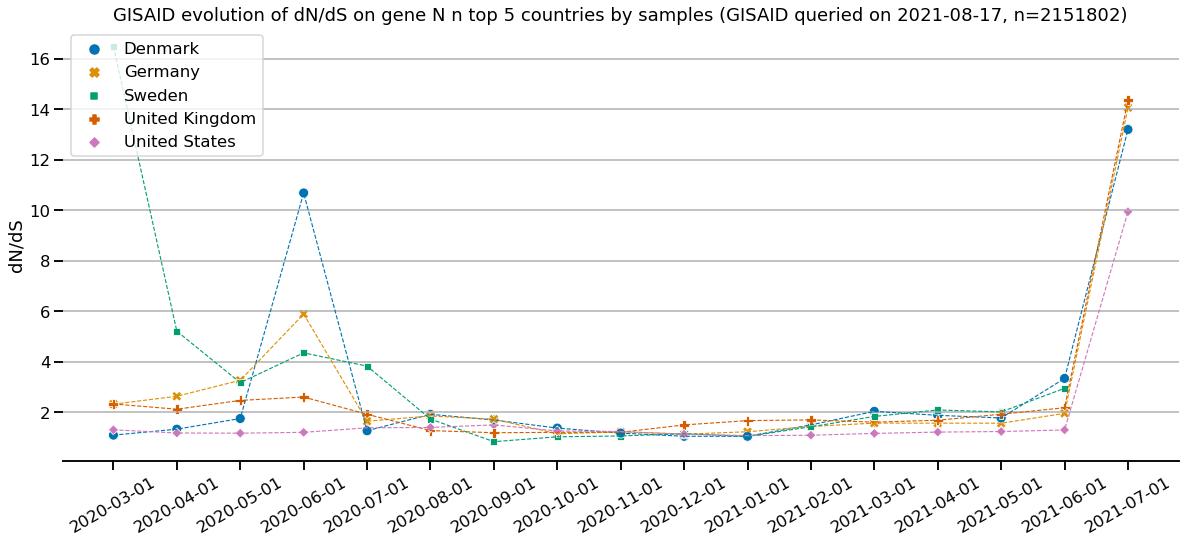

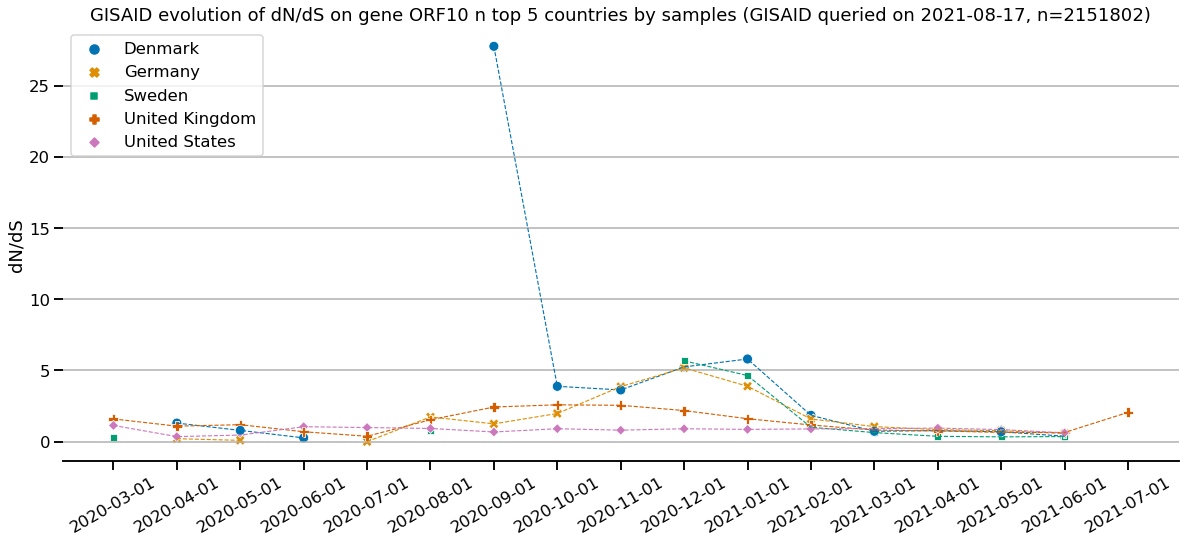

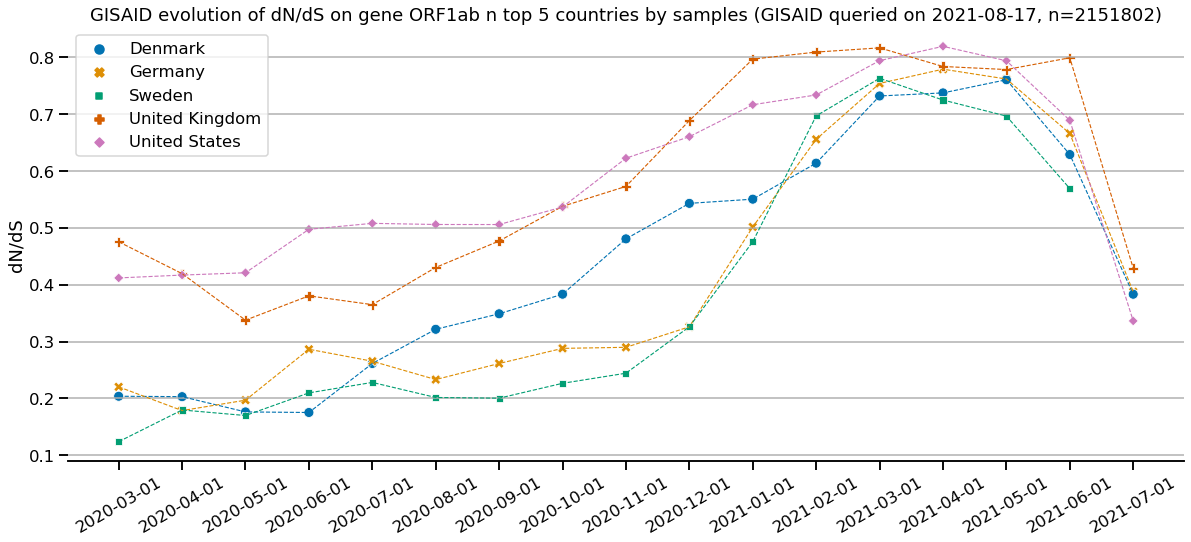

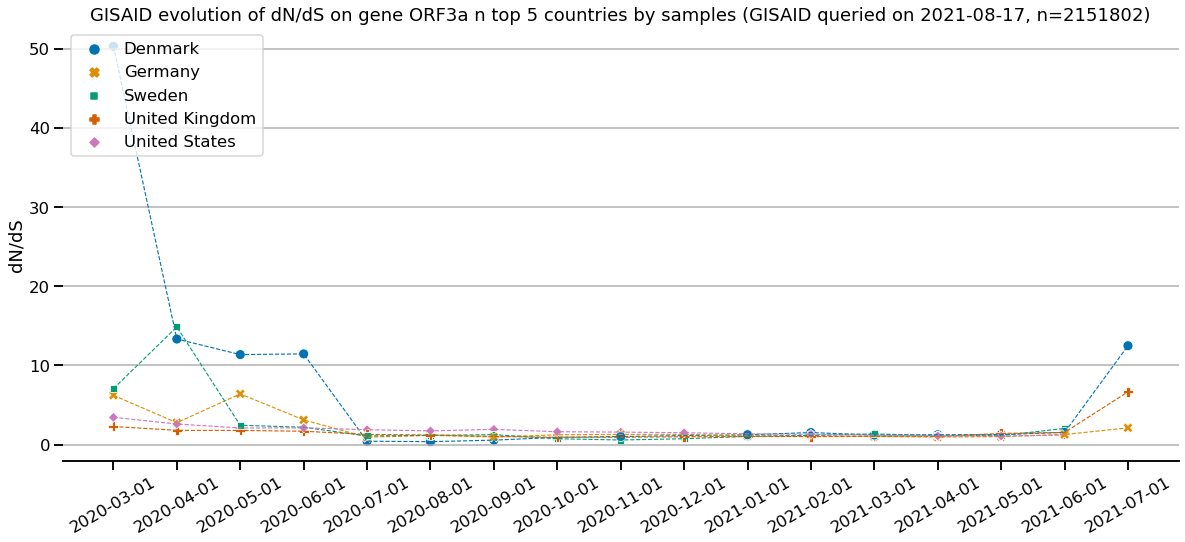

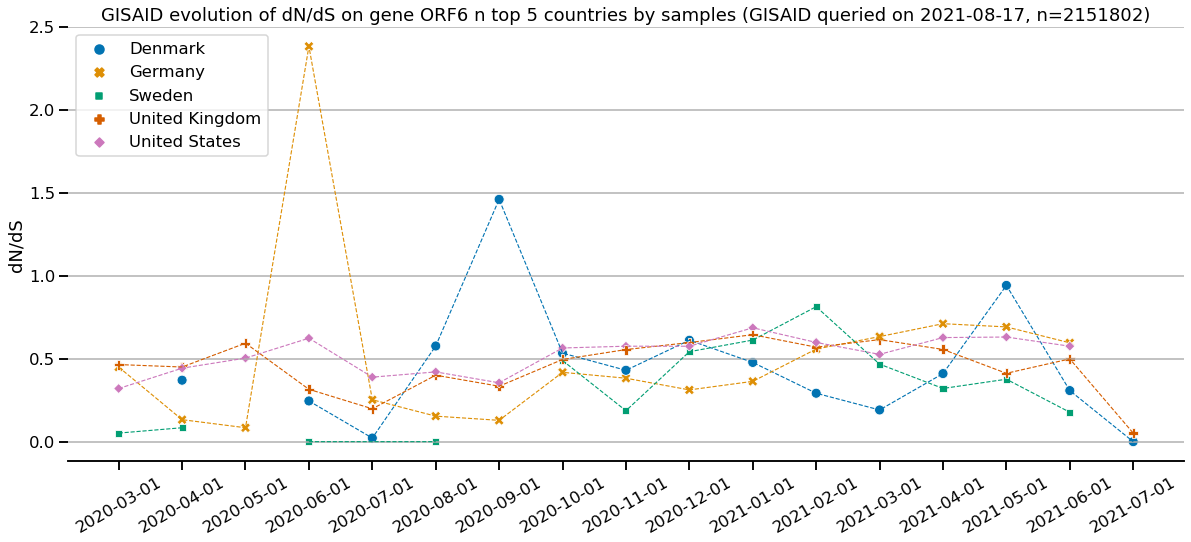

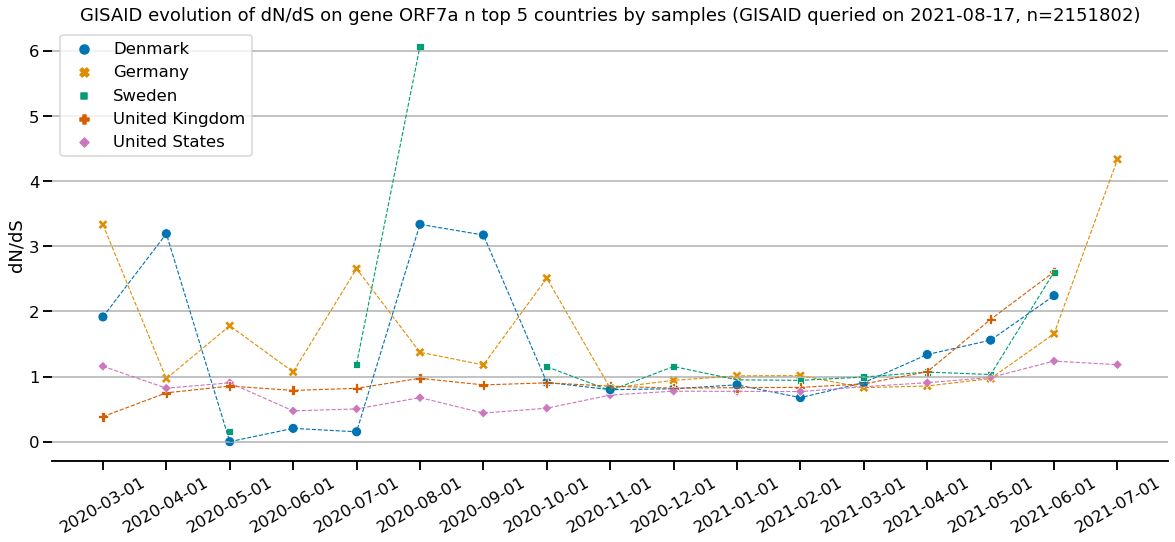

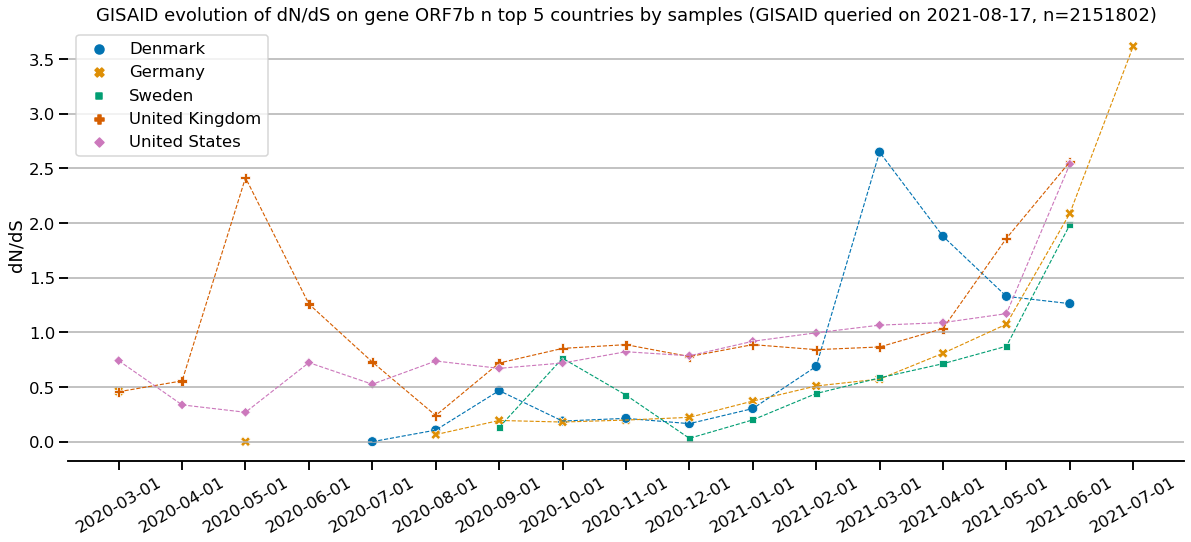

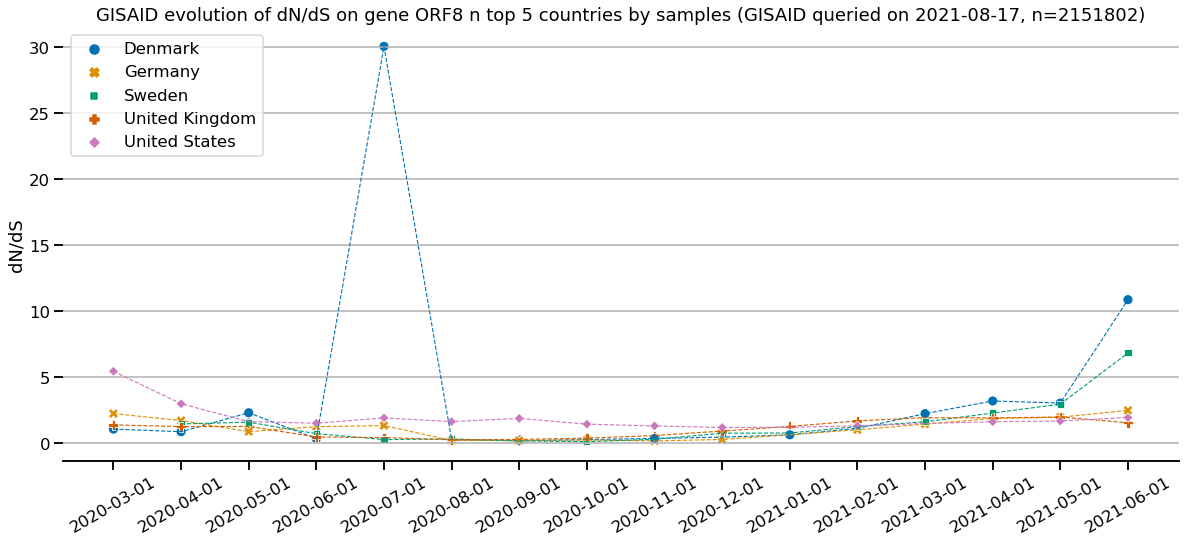

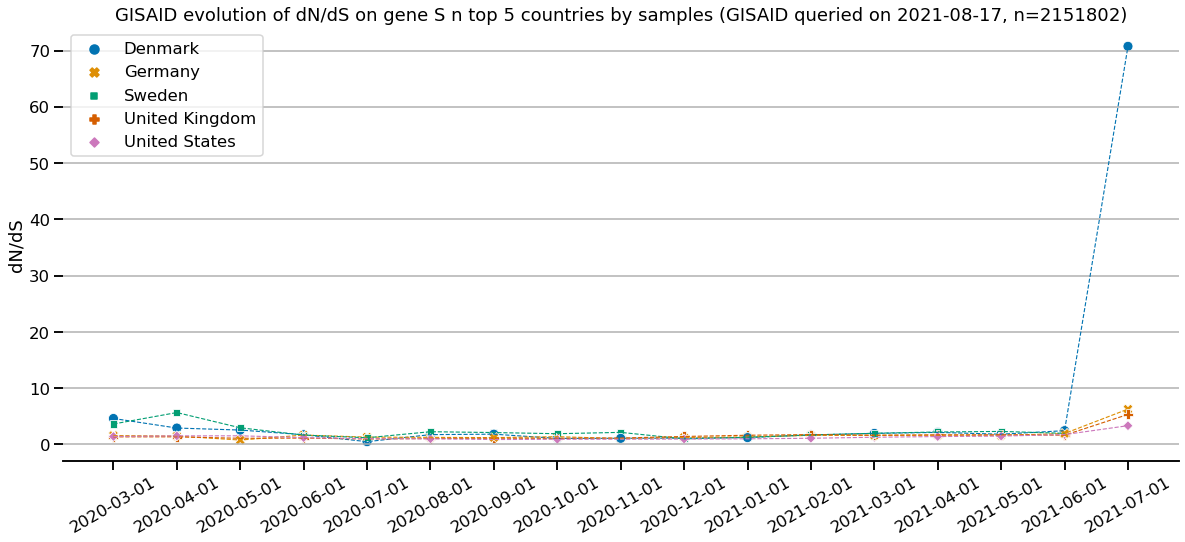

In [25]:
top_countries_gisaid = ["United Kingdom", "United States", "Germany", "Denmark", "Sweden"]
for g in genes:
    plot_dn_ds_by_country(
        data=genes_counts_mutations_ns_s[
            (genes_counts_mutations_ns_s.source == "GISAID") & 
            (genes_counts_mutations_ns_s.region_name == g) & 
            (genes_counts_mutations_ns_s.country.isin(top_countries_gisaid)) & 
            (genes_counts_mutations_ns_s.month >= "2020-03-01")], 
        title="GISAID evolution of dN/dS on gene {gene} n top 5 countries by samples (GISAID queried on {date}, n={num_samples})".format(
            gene=g, date=gisaid_download_date, num_samples=gisaid_num_samples), 
        filename=os.path.join(figures_folder, "dn_ds_{gene}_by_month_top5_countries_gisaid.png".format(gene=g)),
        N=counts_fractions_ns_s[counts_fractions_ns_s.gene == g].NS.iloc[0],
        S=counts_fractions_ns_s[counts_fractions_ns_s.gene == g].S.iloc[0]
    )

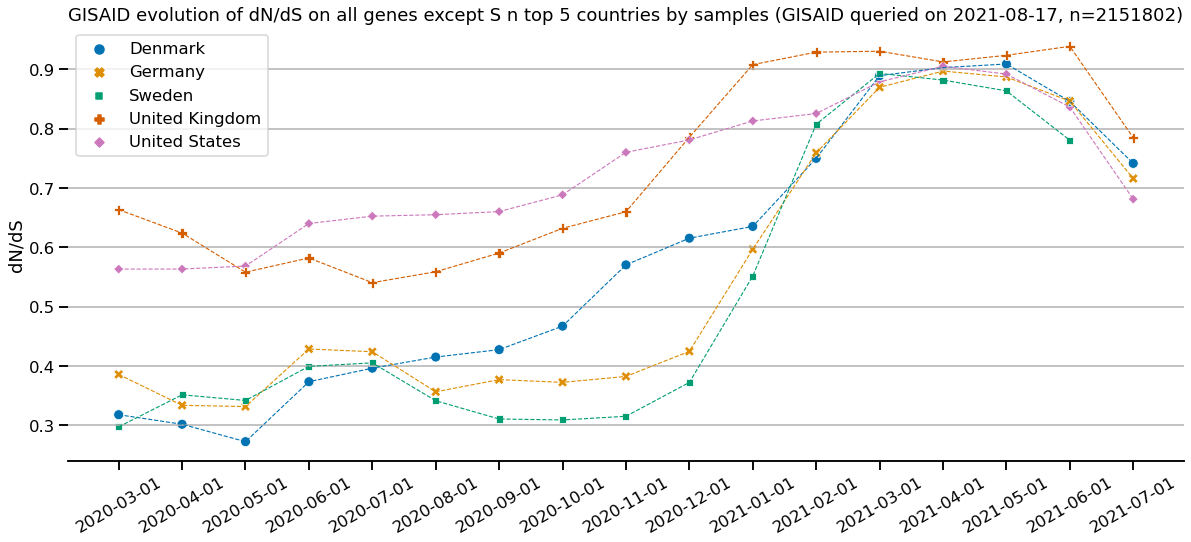

In [26]:
plot_dn_ds_by_country(
        data=genes_counts_mutations_ns_s[
            (genes_counts_mutations_ns_s.source == "GISAID") & 
            (genes_counts_mutations_ns_s.region_name != 'S') & 
            (genes_counts_mutations_ns_s.country.isin(top_countries_gisaid)) & 
            (genes_counts_mutations_ns_s.month >= "2020-03-01")], 
        title="GISAID evolution of dN/dS on all genes except S n top 5 countries by samples (GISAID queried on {date}, n={num_samples})".format(
            gene=g, date=gisaid_download_date, num_samples=gisaid_num_samples), 
        filename=os.path.join(figures_folder, "dn_ds_all_genes_except_S_by_month_top5_countries_gisaid.png".format(gene=g)),
        N=counts_fractions_ns_s[counts_fractions_ns_s.gene != "S"].NS.sum(),
        S=counts_fractions_ns_s[counts_fractions_ns_s.gene != "S"].S.sum()
    )

### dN/dS on the coding region by country

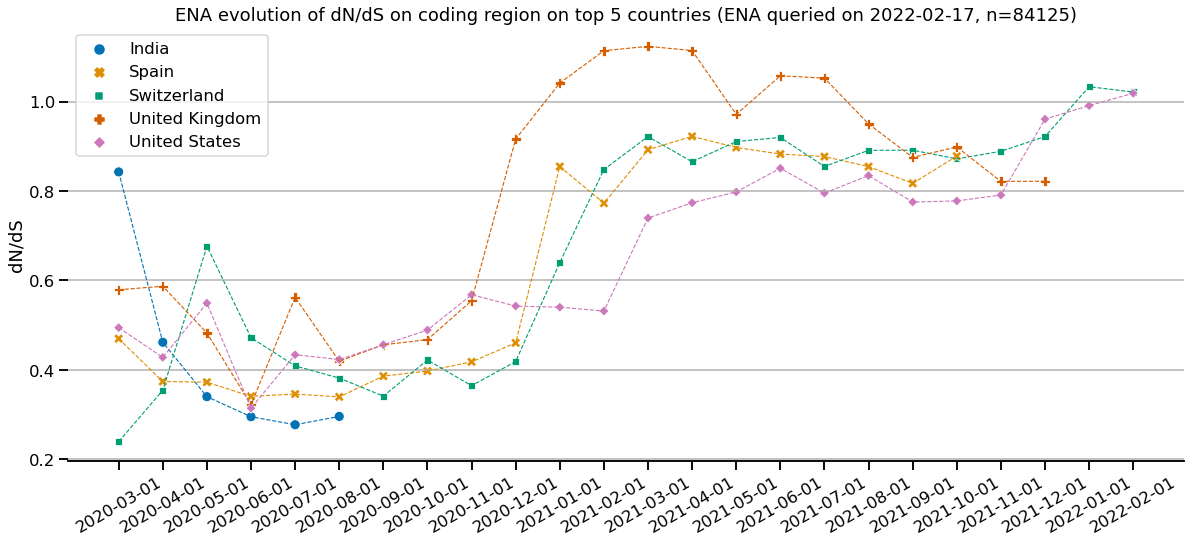

In [27]:
plot_dn_ds_by_country(
    data=genes_counts_mutations_ns_s[
        (genes_counts_mutations_ns_s.source == "ENA") & 
        (genes_counts_mutations_ns_s.country.isin(top_countries_ena)) & 
        (genes_counts_mutations_ns_s.month >= "2020-03-01")], 
    title="ENA evolution of dN/dS on coding region on top 5 countries (ENA queried on {date}, n={num_samples})".format(date=ena_download_date, num_samples=ena_num_samples), 
    filename=os.path.join(figures_folder, "dn_ds_coding_region_by_month_top5_countries_ena.png"), 
    N=ns_coding_region,
    S=s_coding_region
)

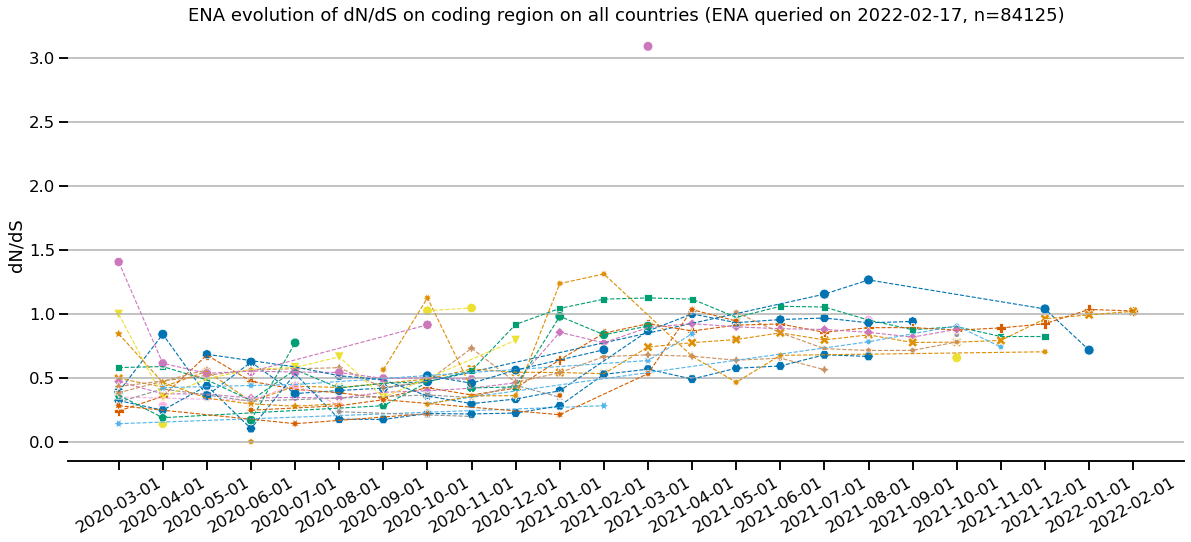

In [28]:
plot_dn_ds_by_country(
    data=genes_counts_mutations_ns_s[
        (genes_counts_mutations_ns_s.source == "ENA") & 
        (genes_counts_mutations_ns_s.month >= "2020-03-01")], 
    title="ENA evolution of dN/dS on coding region on all countries (ENA queried on {date}, n={num_samples})".format(date=ena_download_date, num_samples=ena_num_samples), 
    filename=os.path.join(figures_folder, "dn_ds_coding_region_by_month_all_countries_ena.png"), legend=False, 
    N=ns_coding_region,
    S=s_coding_region)

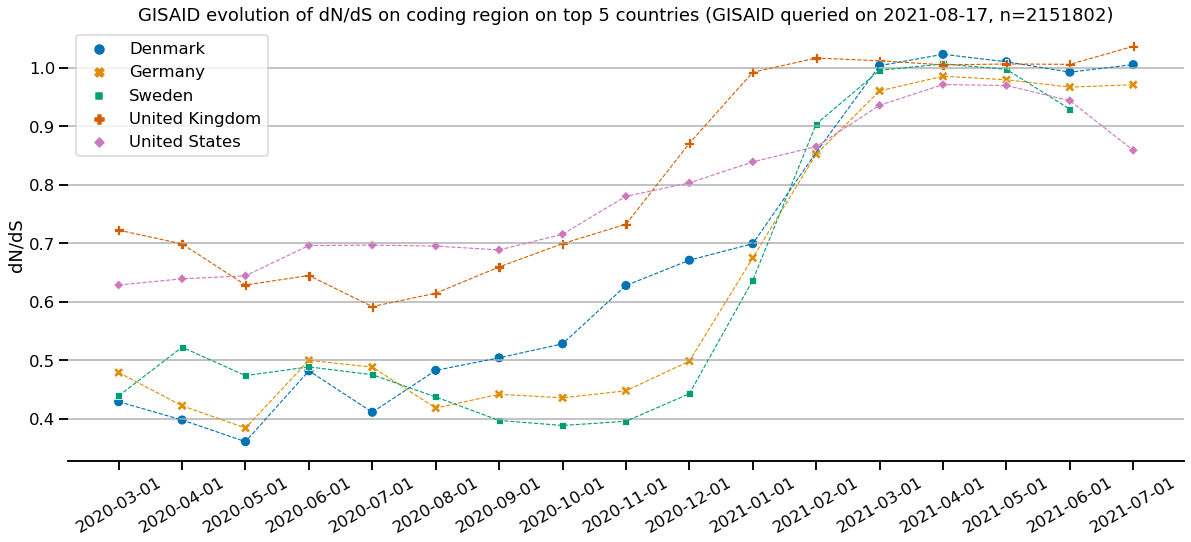

In [29]:
plot_dn_ds_by_country(
    data=genes_counts_mutations_ns_s[
        (genes_counts_mutations_ns_s.source == "GISAID") & 
        (genes_counts_mutations_ns_s.country.isin(top_countries_gisaid)) & 
        (genes_counts_mutations_ns_s.month >= "2020-03-01")], 
    title="GISAID evolution of dN/dS on coding region on top 5 countries (GISAID queried on {date}, n={num_samples})".format(date=gisaid_download_date, num_samples=gisaid_num_samples), 
    filename=os.path.join(figures_folder, "dn_ds_coding_region_by_month_top5_countries_gisaid.png"), 
    N=ns_coding_region,
    S=s_coding_region)

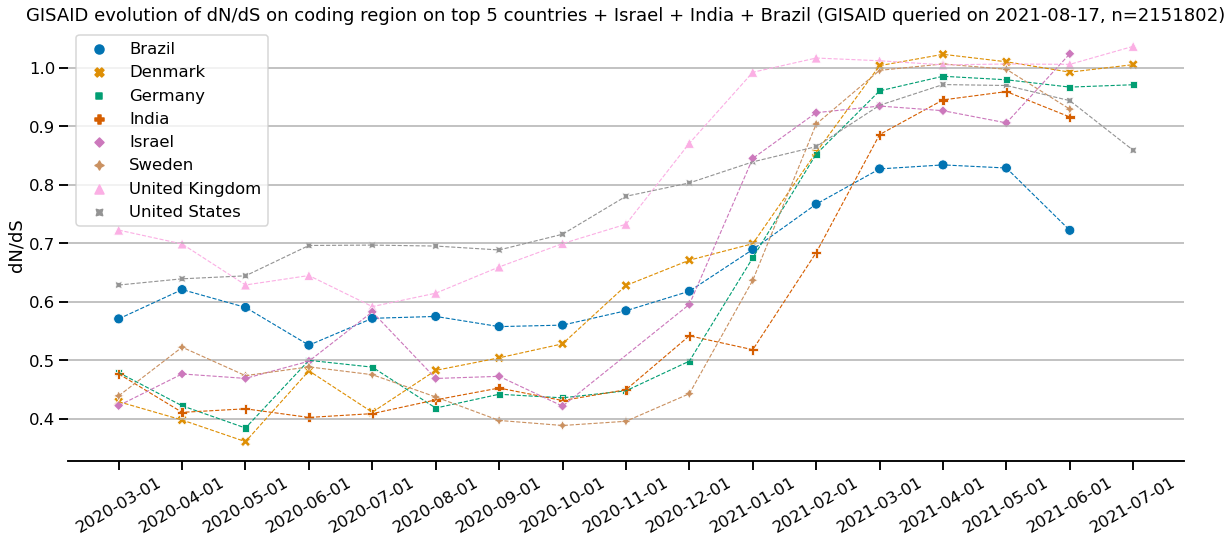

In [30]:
plot_dn_ds_by_country(
    data=genes_counts_mutations_ns_s[
        (genes_counts_mutations_ns_s.source == "GISAID") & 
        (genes_counts_mutations_ns_s.country.isin(top_countries_gisaid + ["Israel", "India", "Brazil"])) & 
        (genes_counts_mutations_ns_s.month >= "2020-03-01")], 
    title="GISAID evolution of dN/dS on coding region on top 5 countries + Israel + India + Brazil (GISAID queried on {date}, n={num_samples})".format(date=gisaid_download_date, num_samples=gisaid_num_samples), 
    filename=os.path.join(figures_folder, "dn_ds_coding_region_by_month_top5_israel_india_brazil_countries_gisaid.png"), 
    N=ns_coding_region,
    S=s_coding_region)

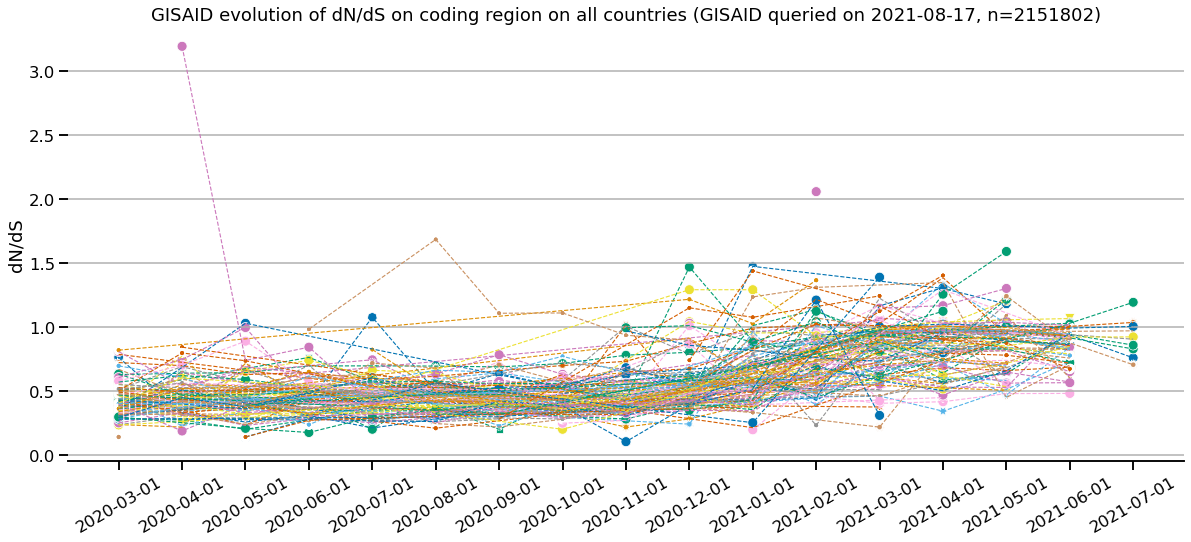

In [31]:
plot_dn_ds_by_country(
    data=genes_counts_mutations_ns_s[
        (genes_counts_mutations_ns_s.source == "GISAID") & 
        (genes_counts_mutations_ns_s.month >= "2020-03-01")], 
    title="GISAID evolution of dN/dS on coding region on all countries (GISAID queried on {date}, n={num_samples})".format(date=gisaid_download_date, num_samples=gisaid_num_samples),
    filename=os.path.join(figures_folder, "dn_ds_coding_region_by_month_all_countries_gisaid.png"), 
    N=ns_coding_region,
    S=s_coding_region, 
    legend=False)

### dN/dS by gene

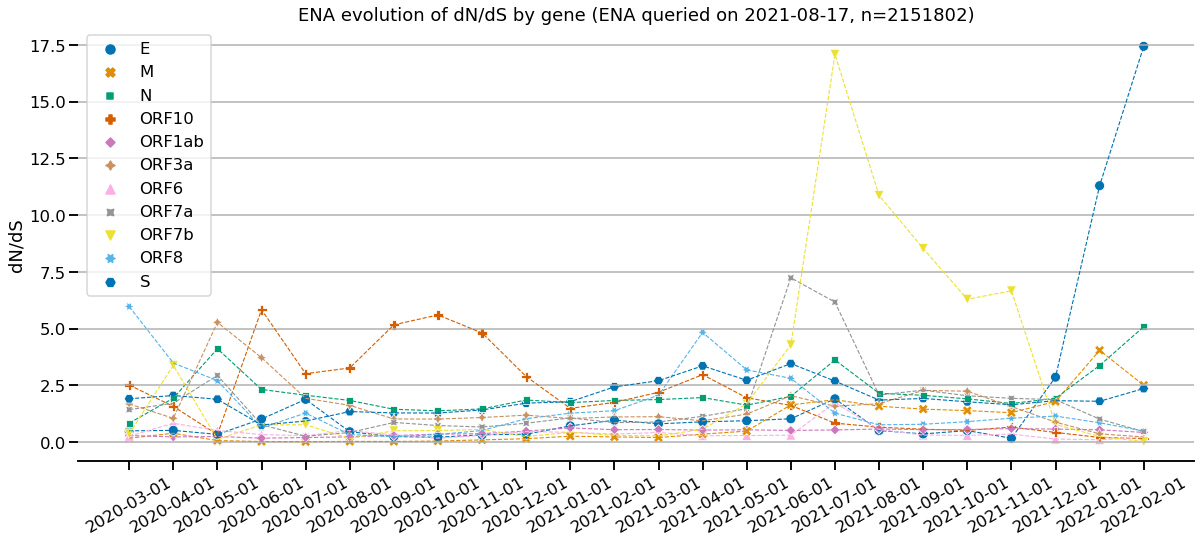

In [32]:
plot_dn_ds_by_gene(
        data=genes_counts_mutations_ns_s[
            (genes_counts_mutations_ns_s.source == "ENA") & 
            (genes_counts_mutations_ns_s.month >= "2020-03-01")],
        data_fractions=counts_fractions_ns_s,
        title="ENA evolution of dN/dS by gene (ENA queried on {date}, n={num_samples})".format(
            date=gisaid_download_date, num_samples=gisaid_num_samples),
        filename=os.path.join(figures_folder, "dn_ds_by_gene_ena.png")
    )

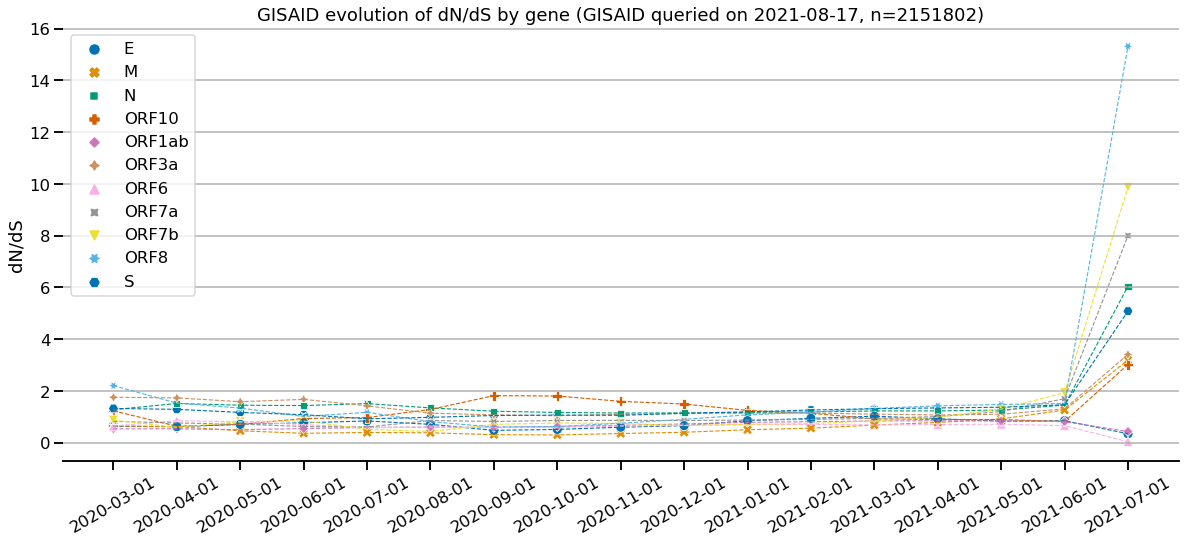

In [33]:
plot_dn_ds_by_gene(
        data=genes_counts_mutations_ns_s[
            (genes_counts_mutations_ns_s.source == "GISAID") & 
            (genes_counts_mutations_ns_s.month >= "2020-03-01")], 
        data_fractions=counts_fractions_ns_s,
        title="GISAID evolution of dN/dS by gene (GISAID queried on {date}, n={num_samples})".format(
            gene=g, date=gisaid_download_date, num_samples=gisaid_num_samples),
        filename=os.path.join(figures_folder, "dn_ds_by_gene_gisaid.png")
    )

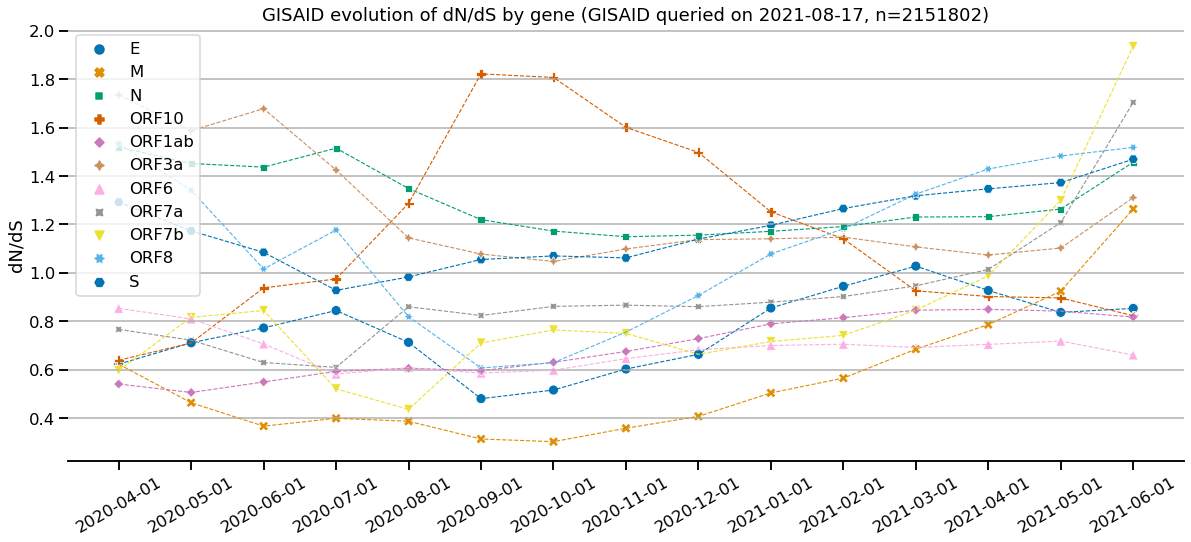

In [34]:
plot_dn_ds_by_gene(
        data=genes_counts_mutations_ns_s[
            (genes_counts_mutations_ns_s.source == "GISAID") & 
            (genes_counts_mutations_ns_s.month >= "2020-04-01") & 
            (genes_counts_mutations_ns_s.month < "2021-07-01")
        ], 
        data_fractions=counts_fractions_ns_s,
        title="GISAID evolution of dN/dS by gene (GISAID queried on {date}, n={num_samples})".format(
            gene=g, date=gisaid_download_date, num_samples=gisaid_num_samples),
        filename=os.path.join(figures_folder, "dn_ds_by_gene_gisaid_between_042020_052021.png")
    )

### dN/dS by domain

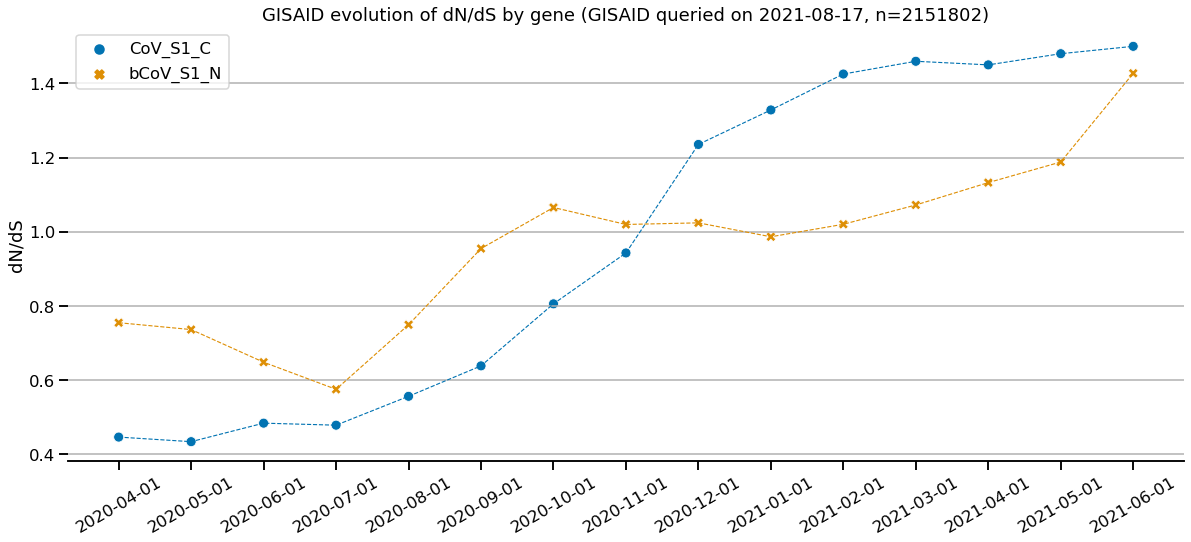

In [35]:
plot_dn_ds_by_domain(
        data=domain_counts_mutations_ns_s[
            (domain_counts_mutations_ns_s.gene == "S") &
            (domain_counts_mutations_ns_s.source == "GISAID") & 
            (domain_counts_mutations_ns_s.month >= "2020-04-01") & 
            (domain_counts_mutations_ns_s.month < "2021-07-01")
        ], 
        data_fractions=counts_fractions_ns_s_domain[counts_fractions_ns_s_domain.gene == "S"],
        title="GISAID evolution of dN/dS by gene (GISAID queried on {date}, n={num_samples})".format(
            gene=g, date=gisaid_download_date, num_samples=gisaid_num_samples),
        filename=os.path.join(figures_folder, "dn_ds_by_domain_gisaid_except_between_042020_062021.png")
    )

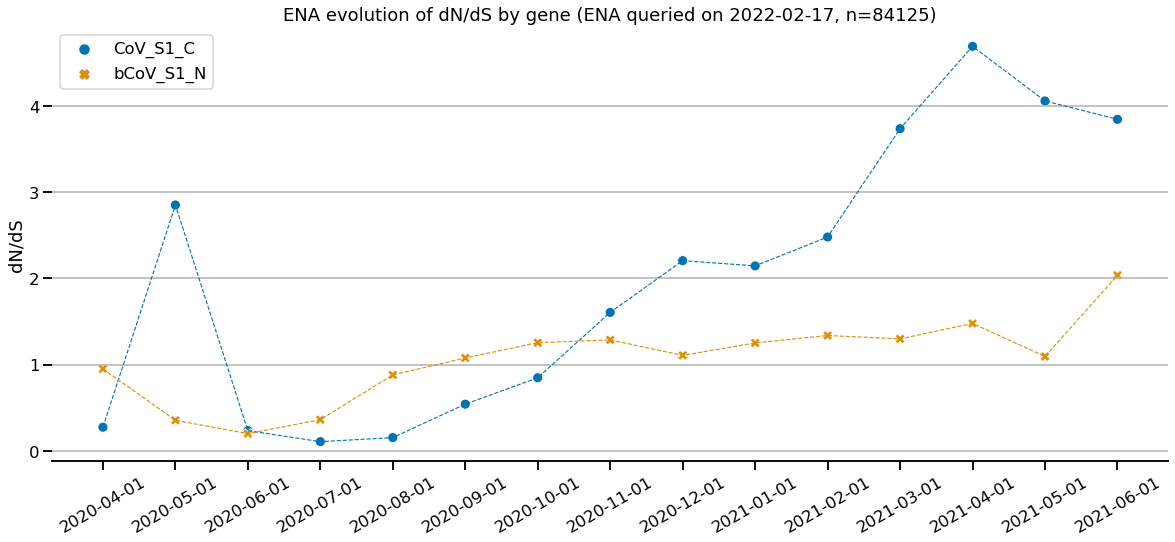

In [36]:
plot_dn_ds_by_domain(
        data=domain_counts_mutations_ns_s[
            (domain_counts_mutations_ns_s.gene == "S") &
            (domain_counts_mutations_ns_s.source == "ENA") & 
            (domain_counts_mutations_ns_s.month >= "2020-04-01") & 
            (domain_counts_mutations_ns_s.month < "2021-07-01")
        ], 
        data_fractions=counts_fractions_ns_s_domain[counts_fractions_ns_s_domain.gene == "S"],
        title="ENA evolution of dN/dS by gene (ENA queried on {date}, n={num_samples})".format(
            gene=g, date=ena_download_date, num_samples=ena_num_samples),
        filename=os.path.join(figures_folder, "dn_ds_by_domain_ena_except_between_042020_062021.png")
    )

### dN/dS and vaccination

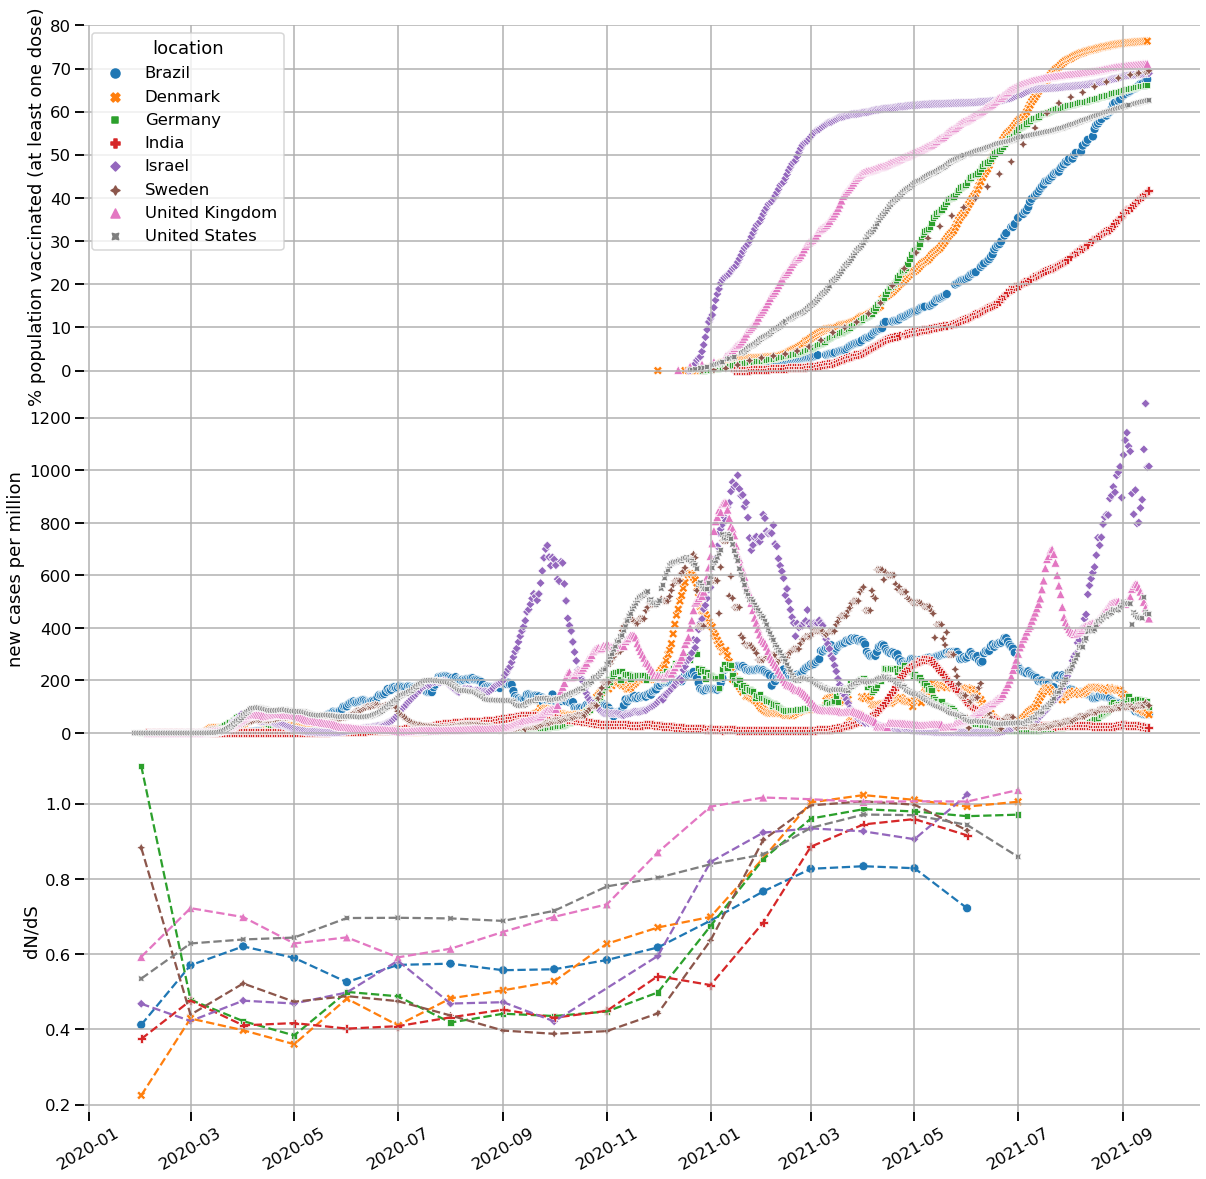

In [37]:
vaccination_data_to_plot = vaccination_data[vaccination_data.location.isin(countries_of_interest)][[
    "location", "date", "people_vaccinated_per_hundred", "people_fully_vaccinated_per_hundred", "new_cases_smoothed_per_million"]]
# & (data.region_name == "S")
dn_ds_data_to_plot = genes_counts_mutations_ns_s[
    (genes_counts_mutations_ns_s.source == "GISAID") & 
    (genes_counts_mutations_ns_s.country.isin(countries_of_interest)) & 
    (genes_counts_mutations_ns_s.month >= "2020-02-01")]
dn_ds_data_to_plot = dn_ds_data_to_plot.groupby(["month", "country"]).sum().reset_index().sort_values("month")
dn_ds_data_to_plot["dn_ds"] = dn_ds_data_to_plot[["s", "ns"]].apply(
    lambda x: calculate_dn_ds(s=x[0], n=x[1], S=s_coding_region, N=ns_coding_region), axis=1)
dn_ds_data_to_plot.month = pd.to_datetime(dn_ds_data_to_plot.month)

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(20, 20), gridspec_kw={'height_ratios': [3, 3, 3]})
#sns.lineplot(data=vaccination_data_to_plot, x="date", y="people_vaccinated_per_hundred", hue="location", legend=False, linestyle="--", ax=ax1)
sns.scatterplot(data=vaccination_data_to_plot, x="date", y="people_vaccinated_per_hundred", hue="location", style="location", legend=True, ax=ax1)

#sns.lineplot(data=vaccination_data_to_plot, x="date", y="new_cases_smoothed_per_million", hue="location", legend=False, linestyle="--", ax=ax2)
sns.scatterplot(data=vaccination_data_to_plot, x="date", y="new_cases_smoothed_per_million", hue="location", style="location", legend=False, ax=ax2)

sns.lineplot(data=dn_ds_data_to_plot, x="month", y="dn_ds", hue="country", linestyle="--", legend=False, ax=ax3)
sns.scatterplot(data=dn_ds_data_to_plot, x="month", y="dn_ds", hue="country", style="country", legend=False, ax=ax3)

sns.despine(bottom=True, left=True)
ax1.grid(axis="x")
ax1.grid(axis="y")
ax2.grid(axis="x")
ax2.grid(axis="y")
ax3.grid(axis="x")
ax3.grid(axis="y")
ax1.set_ylabel("% population vaccinated (at least one dose)")
ax2.set_ylabel("new cases per million")
ax3.set_ylabel("dN/dS")
ax3.set_xlabel(None)
plt.xticks(rotation=30)
plt.subplots_adjust(hspace=0.0)
plt.savefig(os.path.join(figures_folder, "dnds_versus_people_fully_vaccinated_per_hundred.png"))